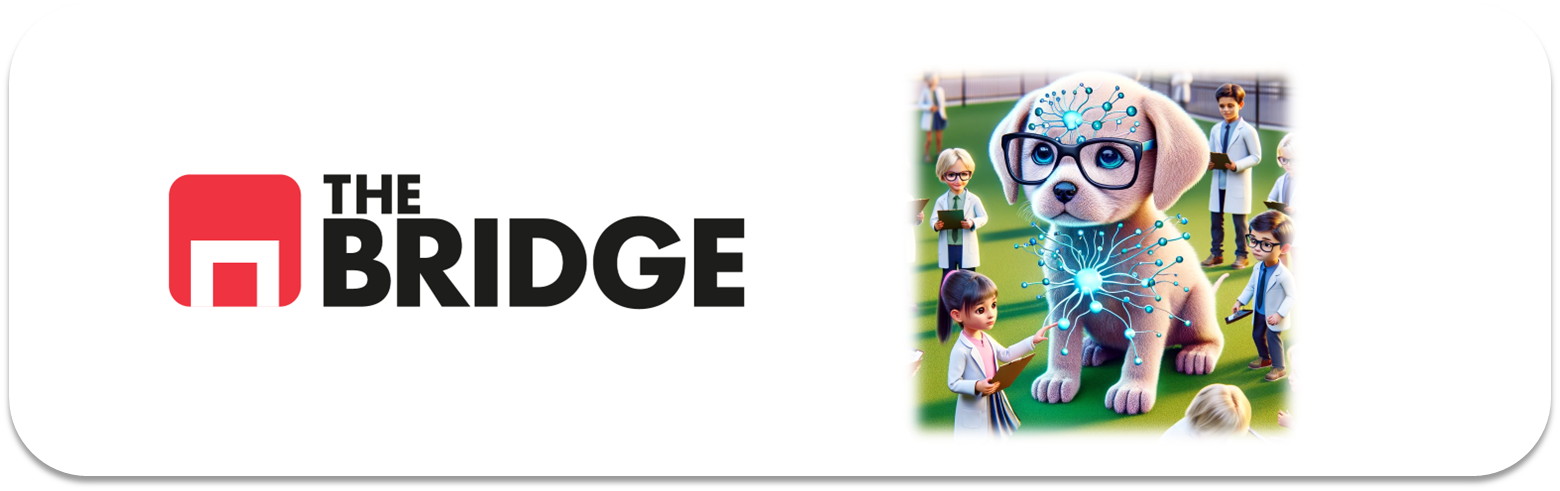

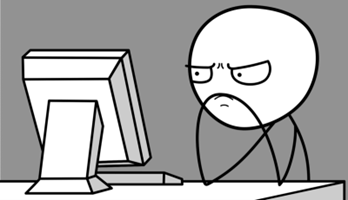

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [2]:
df = pd.read_csv('./data/air_pollution_new_city.csv', sep = "|")

In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
target = "pm2.5"

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [5]:
df_indexed = df.copy()
df_indexed["date"] = df_indexed["year"].astype(str) + "-" + df_indexed["month"].astype(str) + "-" + df_indexed["day"].astype(str) + " " + df_indexed["hour"].astype(str) + ":00:00"
df_indexed["date"] = pd.to_datetime(df_indexed["date"], format="%Y-%m-%d %H:%M:%S")
df_indexed = df_indexed.set_index("date")

In [6]:
df_indexed = df_indexed.drop(["No", "year", "month", "day", "hour"], axis=1)

In [7]:
df_indexed.sort_index(inplace=True)
df_indexed.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

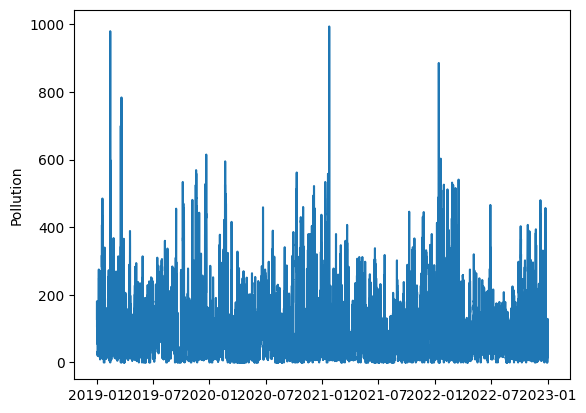

In [8]:
df_train = df_indexed[:"2022"]

plt.plot(df_train[target])
plt.ylabel("Pollution")
plt.show()

No se ve mucho si hay una tendencia o estacionalidad

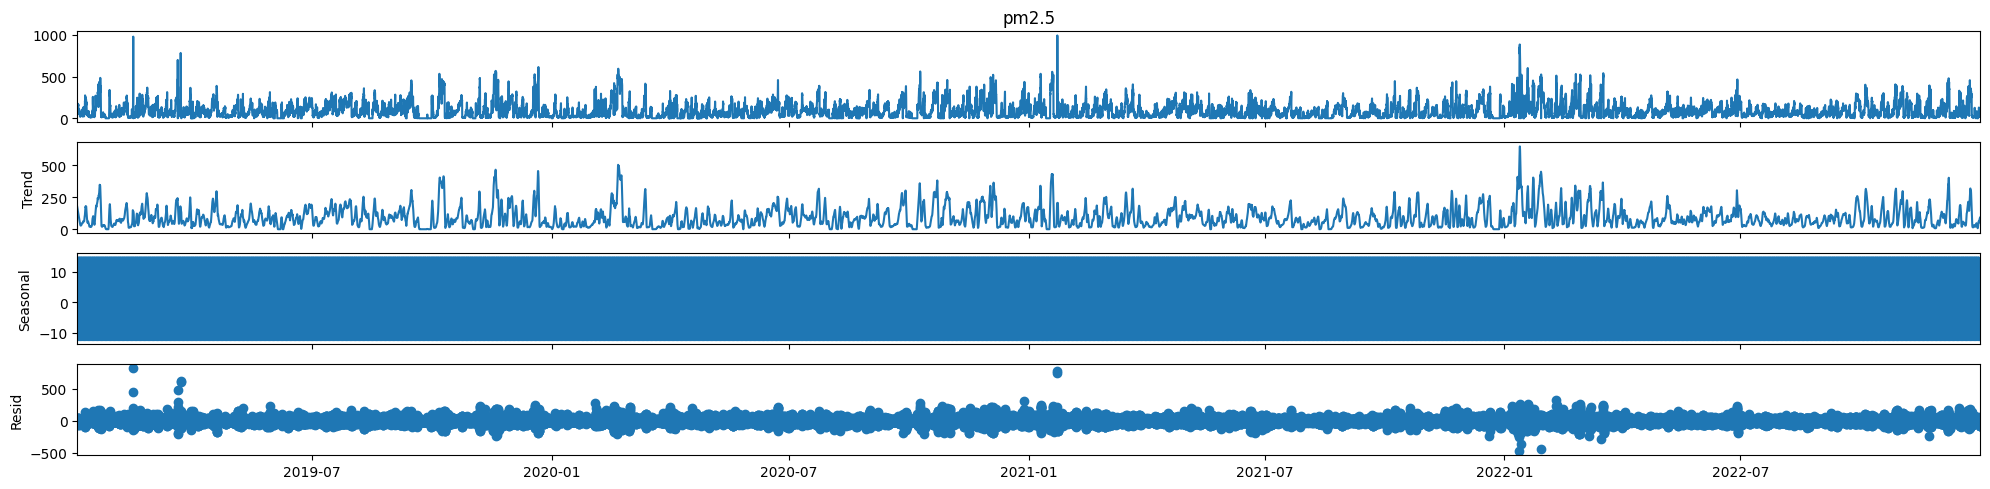

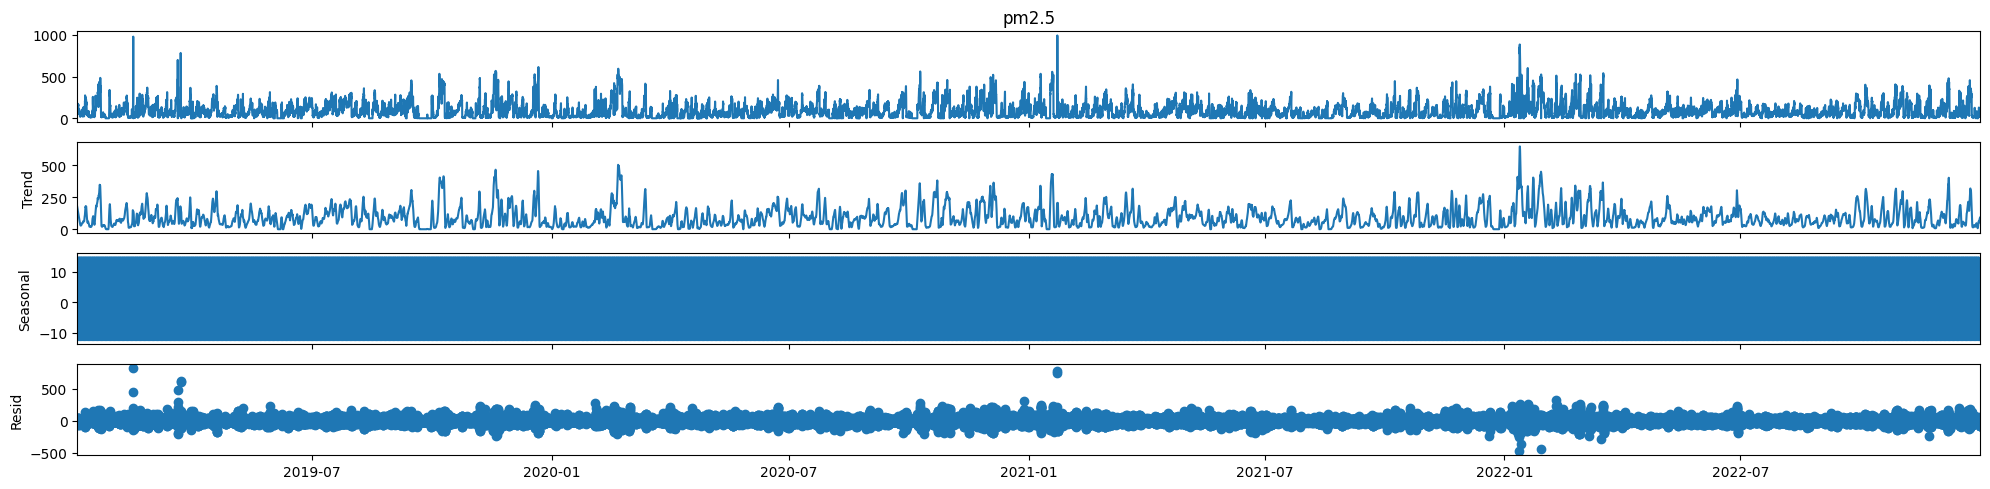

In [9]:
result_add = seasonal_decompose(df_train[target], model = 'additive', extrapolate_trend = 'freq')
plt.rcParams.update({'figure.figsize': (20,5)})
result_add.plot()

In [10]:
df[target].describe()

count    43800.000000
mean        94.013516
std         92.252276
min          0.000000
25%         24.000000
50%         68.000000
75%        132.250000
max        994.000000
Name: pm2.5, dtype: float64

La tendencia sigue básicamente la serie. No parece que exista una tendencia o estacionalidad a nivel horario.

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

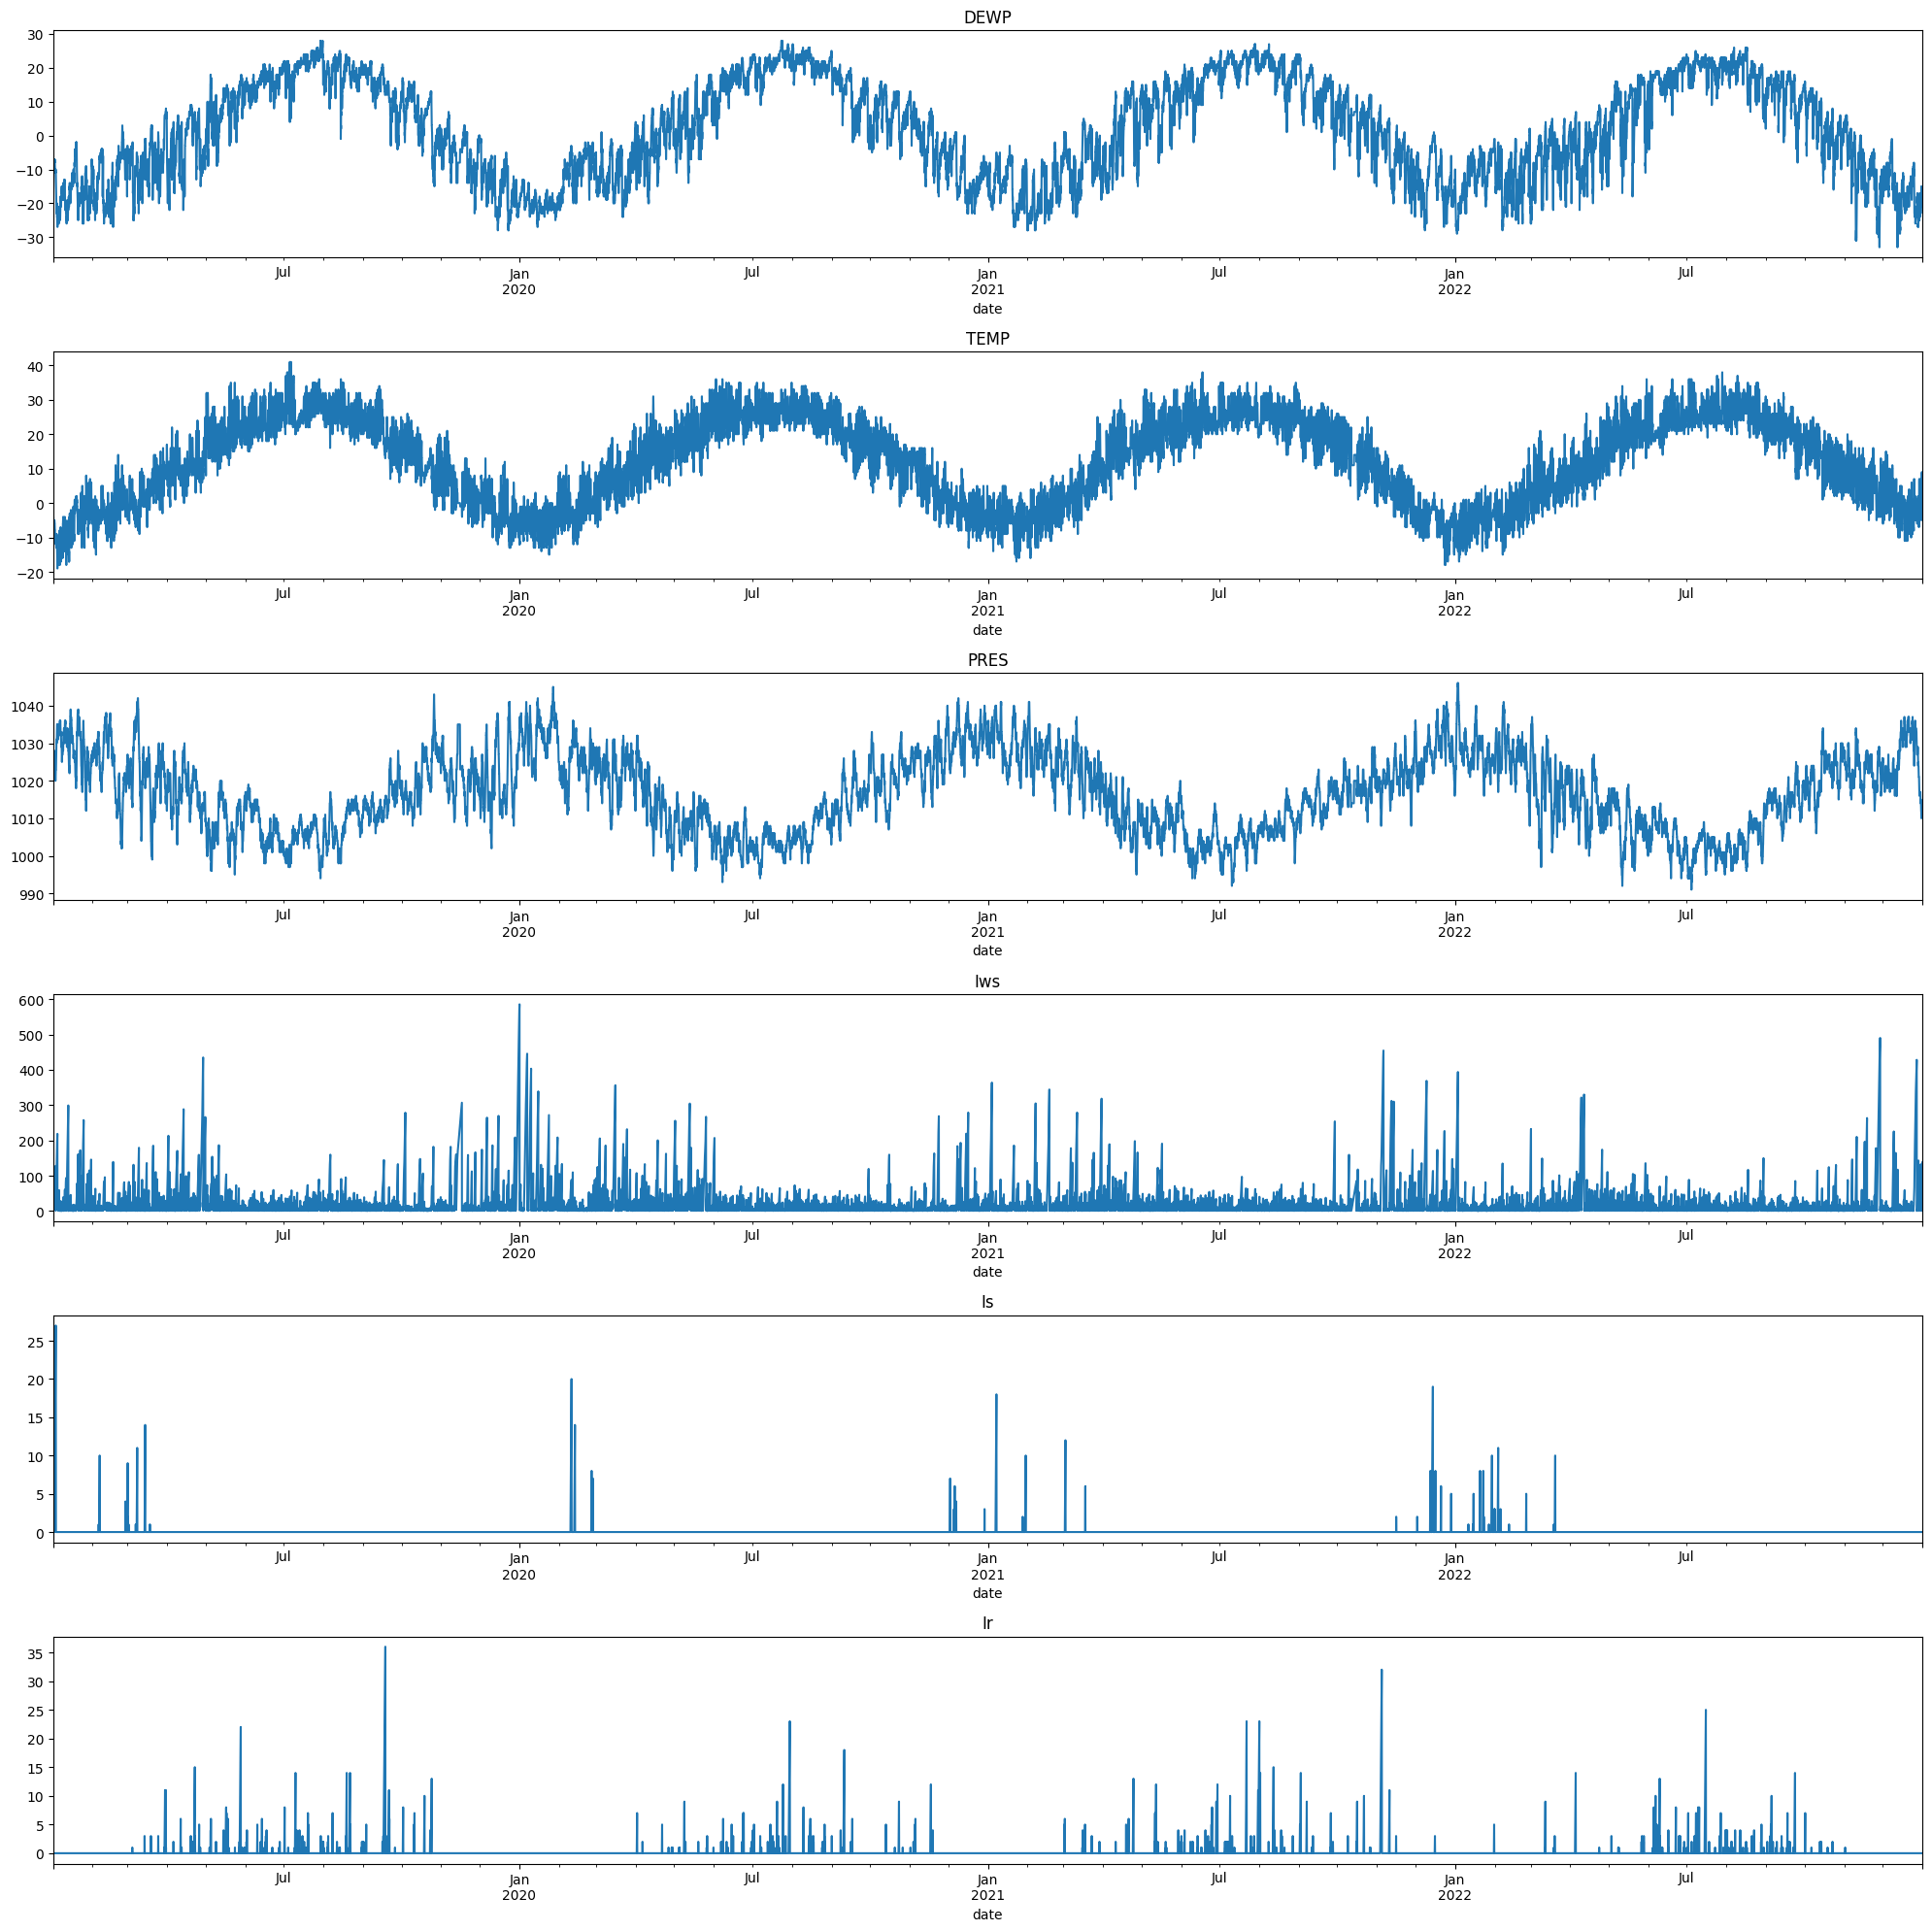

In [11]:
series_col = [col for col in df_train.columns if col != df_train[col].dtype != 'object' and col != target]

fig,axs = plt.subplots(len(series_col),1, figsize = (20,20))
for indice,col in enumerate(series_col):
    df_train[col].plot(ax = axs[indice])
    axs[indice].set_title(col)
plt.tight_layout();

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [12]:
wind_dummies = pd.get_dummies(df_indexed["cbwd"], drop_first = True, dtype = "float32")
wind_dummies.columns = ["direccion_viento_" + str(col) for col in wind_dummies.columns]
df_indexed = df_indexed.drop(["cbwd"], axis = 1)
df_indexed = pd.concat([df_indexed, wind_dummies], axis = 1)

In [13]:
df_indexed = df_indexed.astype('float32')

In [14]:
df_indexed.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
date,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,1.0,0.0


### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [15]:
df_train_mulvar = df_indexed[:"2023-09"].copy()
df_val_mulvar = df_indexed["2023-09-29":"2023-11-01"].copy()
df_test_mulvar = df_indexed["2023-10-30":"2023-12-01"].copy()

# Escalado
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train_mulvar[series_col] = scaler.fit_transform(df_train_mulvar[series_col])
df_val_mulvar[series_col] = scaler.transform(df_val_mulvar[series_col])
df_test_mulvar[series_col] = scaler.transform(df_test_mulvar[series_col])

# Escalado de la target
scaler_target = StandardScaler()
df_train_mulvar[target] = scaler_target.fit_transform(df_train_mulvar[[target]])
df_val_mulvar[target] = scaler_target.transform(df_val_mulvar[[target]])
df_test_mulvar[target] = scaler_target.transform(df_test_mulvar[[target]])

### Ejercicio 7
Prepara los batches siguiendo los pasos que has visto en el workload para multivariante y periodos múltiples

In [16]:
seq_length = 48
prediction_interval = 6

def split_inputs_and_targets(mulvar_series, ahead= prediction_interval, target_col= list(df_indexed.columns).index(target)):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
    shuffle=True,
    seed=42).map(split_inputs_and_targets)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_val_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
    shuffle=False).map(split_inputs_and_targets)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32,
    shuffle=False).map(split_inputs_and_targets)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [17]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None, scaler = scaler_target):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mae","root_mean_squared_error"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae, valid_rmse = model.evaluate(valid_set)
    return scaler_target.inverse_transform([[valid_mae, valid_rmse]])

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (seq_length, len(df_train_mulvar.columns))),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(prediction_interval),])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574 (6.15 KB)

 Trainable params: 1,574 (6.15 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
fit_and_evaluate(model, train_ds, val_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3298 - mae: 0.3599 - root_mean_squared_error: 0.5685 - val_loss: 0.2789 - val_mae: 0.3411 - val_root_mean_squared_error: 0.5281
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2498 - mae: 0.3039 - root_mean_squared_error: 0.4997 - val_loss: 0.2618 - val_mae: 0.3239 - val_root_mean_squared_error: 0.5117
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2433 - mae: 0.3002 - root_mean_squared_error: 0.4932 - val_loss: 0.2606 - val_mae: 0.3282 - val_root_mean_squared_error: 0.5105
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2406 - mae: 0.2996 - root_mean_squared_error: 0.4905 - val_loss: 0.2500 - val_mae: 0.3187 - val_root_mean_squared_error: 0.5000
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2379 - mae: 0.2972 - root_mean_squared_error: 0.4877 - val_loss: 0.2529 - val_mae: 0.3173 - val_root_mean_squared_error: 0.5029
Epoch 6/100
1299/1299 ━━━━━━━━━━━━━

array([[121.5162524 , 137.39199546]])

In [20]:
_, mae, rmse = model.evaluate(test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2560 - mae: 0.2727 - root_mean_squared_error: 0.4948


array([[123.87036649, 149.16704958]])

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (seq_length, len(df_train_mulvar.columns))),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(prediction_interval)
])
lstm_model.summary()
fit_and_evaluate(lstm_model, train_ds, val_ds, epochs = 100, learning_rate=0.01)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,702 (22.27 KB)

 Trainable params: 5,702 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.3568 - mae: 0.3823 - root_mean_squared_error: 0.5924 - val_loss: 0.2499 - val_mae: 0.3246 - val_root_mean_squared_error: 0.4999
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.2434 - mae: 0.3004 - root_mean_squared_error: 0.4933 - val_loss: 0.2298 - val_mae: 0.3036 - val_root_mean_squared_error: 0.4794
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.2341 - mae: 0.2924 - root_mean_squared_error: 0.4837 - val_loss: 0.2229 - val_mae: 0.3008 - val_root_mean_squared_error: 0.4722
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.2291 - mae: 0.2886 - root_mean_squared_error: 0.4785 - val_loss: 0.2232 - val_mae: 0.2977 - val_root_mean_squared_error: 0.4724
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.2253 - mae: 0.2856 - root_mean_squared_error: 0.4746 - val_loss: 0.2166 - val_mae: 0.2950 - val_root_mean_squared_error: 0.4654
Epoch 6/100
1299/1299 ━━━

array([[119.49126461, 134.6871325 ]])

In [22]:
_, mae, rmse = lstm_model.evaluate(test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2415 - mae: 0.2726 - root_mean_squared_error: 0.4798


array([[123.61832591, 146.62770978]])

No mejora mucho el resultado en comparación con el modelo inicial

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [23]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (seq_length, len(df_train_mulvar.columns))),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(prediction_interval)
])
gru_model.summary()
fit_and_evaluate(gru_model, train_ds, val_ds, epochs = 100, learning_rate=0.01)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,422 (17.27 KB)

 Trainable params: 4,422 (17.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.3275 - mae: 0.3548 - root_mean_squared_error: 0.5674 - val_loss: 0.2671 - val_mae: 0.3357 - val_root_mean_squared_error: 0.5169
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.2499 - mae: 0.2986 - root_mean_squared_error: 0.4998 - val_loss: 0.2529 - val_mae: 0.3220 - val_root_mean_squared_error: 0.5029
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.2428 - mae: 0.2944 - root_mean_squared_error: 0.4927 - val_loss: 0.2438 - val_mae: 0.3139 - val_root_mean_squared_error: 0.4937
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.2371 - mae: 0.2922 - root_mean_squared_error: 0.4868 - val_loss: 0.2349 - val_mae: 0.3075 - val_root_mean_squared_error: 0.4847
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.2330 - mae: 0.2897 - root_mean_squared_error: 0.4826 - val_loss: 0.2352 - val_mae: 0.3111 - val_root_mean_squared_error: 0.4850
Epoch 6/100
1299/1299 ━━━

array([[117.7924267 , 131.99008809]])